In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import model

In [2]:
np.random.seed(0)

In [3]:
def shuffle_data(x_data, y_data): # shuffles dataset x and y
    y_data = y_data[np.newaxis, :] # convert label array to 2d
    dataset = np.concatenate((x_data, y_data.T), axis=1) # append labels to data
    np.random.shuffle(dataset) # in-place shuffle dataset
    # peel labels from data
    y_data = dataset[: , -1:]
    y_data = y_data.flatten() # turn back into 1D array
    x_data = dataset[: , :-1]
    y_data = y_data.astype(int)
    return x_data, y_data

In [4]:
def one_hot(original_label):
    data_size = len(original_label)
    label_temp = np.zeros((data_size, 47), dtype = np.float32)
    for i in range(data_size):
        label_temp[i][original_label[i]] = 1
    onehot_label = np.copy(label_temp)
    return onehot_label

In [5]:
def plotGraph(x1, y1, x2, y2, x_axis="epoch", y_axis="Accuracy", label1="train", label2="validation"):

    # plotting the line 1 points  
    plt.plot(x1, y1, label = label1) 
    # plotting the line 2 points  
    plt.plot(x2, y2, label = label2) 
    
    # naming the x axis 
    plt.xlabel(x_axis) 
    # naming the y axis 
    plt.ylabel(y_axis) 
    # giving a title to my graph 
    plt.title(y_axis + " - " + x_axis) 
    
    # show a legend on the plot 
    plt.legend() 
    # function to show the plot 
    plt.show() 

# data loader

In [6]:
# Training .csv  --> first column is label , 1~748 is image value , image size =28*28
# test .csv  --> 0~747 is image value , image size =28*28
#submit your prediction to kaggle

In [7]:
train_load=np.loadtxt("./data/train.csv",dtype=np.int,delimiter=',')
test_data=np.loadtxt("./data/test_nolabel.csv",dtype=np.int,delimiter=',')


train_data=train_load[:,1:]
train_label=train_load[:,0]


In [8]:
print("shape of train_data: {}".format(train_data.shape))
print("shape of train_label: {}".format(train_label.shape))
print("shape of test_data: {}".format(test_data.shape))


shape of train_data: (112800, 784)
shape of train_label: (112800,)
shape of test_data: (18800, 784)


In [9]:
train_image_num = train_data.shape[0]
test_image_num = test_data.shape[0]
print("train_image_num  is : {}".format(train_image_num))
print("test_image_num   is : {}".format(test_image_num))

train_image_num  is : 112800
test_image_num   is : 18800


## Show the data

In [10]:
test_data_show = test_data.reshape(test_image_num, 28,28)

In [11]:
test_data_show.shape

(18800, 28, 28)

plt.figure(figsize=(20, 20))
for index in range(100):
    image = test_data_show[index]
    plt.subplot(10, 10, index+1)
    plt.imshow(image)
plt.show()

#set validation dataset

In [12]:
val_image_num=8000

# Convert the training  labels to one hot 

label_temp = np.zeros((train_image_num, 47), dtype = np.float32)
for i in range(train_image_num):
    label_temp[i][train_label[i]] = 1
train_label_onehot = np.copy(label_temp)
print("One-hot training labels shape:",train_label_onehot.shape)

## Hyperparameters

In [13]:
EPOCH = 15
# Batch_size = 400 #200
Batch_size = 200
val_Batch_size = int(val_image_num / 2)
Learning_rate = 1e-3
# Learning_rate = 3e-5 #10^-5

## Training

In [14]:
net = model.Network()

train_batch_num = (train_image_num  -  val_image_num  )//Batch_size
val_batch_num = (val_image_num)//val_Batch_size


# store for graph plot
epoch_cnt = []
trainAcc_curve = []
valAcc_curve = []
trainLoss_curve = []
valLoss_curve = []

# shuffle once
train_data, train_label = shuffle_data(train_data, train_label)
# separate train and validation sets
val_data = train_data[:val_image_num]
train_data = train_data[val_image_num:]
val_label = train_label[:val_image_num]
train_label = train_label[val_image_num:]


# one-hot validation labels
val_label_onehot = one_hot(val_label)

for epoch in range(1, EPOCH+1):
    # shuffle data
    train_data, train_label = shuffle_data(train_data, train_label)
    # convert one-hot
    train_label_onehot = one_hot(train_label)
    
    
    train_hit = 0
    val_hit = 0
    total_train_loss = 0
    total_val_loss = 0
    for it in range(train_batch_num): # train
        pred, train_loss = net.forward(train_data[it*Batch_size:(it+1)*Batch_size], train_label_onehot[it*Batch_size:(it+1)*Batch_size])
        pred_index = np.argmax(pred, axis=1)
        train_hit += (pred_index==train_label[it*Batch_size:(it+1)*Batch_size]).sum()
        total_train_loss += train_loss
        
        net.backward()
        net.update(Learning_rate, optimizer="adam", curr_epoch=epoch)    
    
    for titt in range(val_batch_num): # validate
        #tit=train_batch_num+titt
        #pred, val_loss = net.forward(train_data[tit*Batch_size:(tit+1)*Batch_size], train_label_onehot[tit*Batch_size:(tit+1)*Batch_size])
        pred, val_loss = net.forward(val_data[titt*val_Batch_size:(titt+1)*val_Batch_size], val_label_onehot[titt*val_Batch_size:(titt+1)*val_Batch_size])
        pred_index = np.argmax(pred, axis=1)
#         val_hit += (pred_index==train_label[tit*Batch_size:(tit+1)*Batch_size]).sum()
        val_hit += (pred_index==val_label[titt*val_Batch_size:(titt+1)*val_Batch_size]).sum()
        total_val_loss += val_loss
        
    # store training and validation accuracy, loss
    epoch_cnt.append(epoch)
    trainAcc_curve.append(train_hit/(train_image_num-val_image_num)*100.0)
    valAcc_curve.append(val_hit/val_image_num*100.0)
    trainLoss_curve.append(total_train_loss/train_batch_num)
    valLoss_curve.append(total_val_loss/val_batch_num)
        
    print('Epoch:%3d'%epoch, '|Train Loss:%8.4f'%(total_train_loss/train_batch_num), '|Train Acc:%3.4f'%(train_hit/(train_image_num-val_image_num)*100.0)
          , '|Val Loss:%8.4f'%(total_val_loss/val_batch_num), '|Val Acc:%3.4f'%(val_hit/val_image_num*100.0))

Epoch:  1 |Train Loss:  0.8560 |Train Acc:73.2586 |Val Loss:  0.5777 |Val Acc:80.8250
Epoch:  2 |Train Loss:  0.4656 |Train Acc:84.0038 |Val Loss:  0.4959 |Val Acc:83.2875
Epoch:  3 |Train Loss:  0.3836 |Train Acc:86.4828 |Val Loss:  0.4687 |Val Acc:84.2125
Epoch:  4 |Train Loss:  0.3373 |Train Acc:87.7748 |Val Loss:  0.4591 |Val Acc:84.7250
Epoch:  5 |Train Loss:  0.3020 |Train Acc:88.9905 |Val Loss:  0.4519 |Val Acc:84.8625
Epoch:  6 |Train Loss:  0.2751 |Train Acc:89.7300 |Val Loss:  0.4500 |Val Acc:85.0500
Epoch:  7 |Train Loss:  0.2519 |Train Acc:90.4571 |Val Loss:  0.4580 |Val Acc:84.9750
Epoch:  8 |Train Loss:  0.2319 |Train Acc:91.1164 |Val Loss:  0.4746 |Val Acc:85.2250
Epoch:  9 |Train Loss:  0.2157 |Train Acc:91.5983 |Val Loss:  0.4847 |Val Acc:85.1625
Epoch: 10 |Train Loss:  0.2003 |Train Acc:92.1260 |Val Loss:  0.4850 |Val Acc:84.8875
Epoch: 11 |Train Loss:  0.1876 |Train Acc:92.4990 |Val Loss:  0.4976 |Val Acc:85.3875
Epoch: 12 |Train Loss:  0.1754 |Train Acc:92.9475 |Val

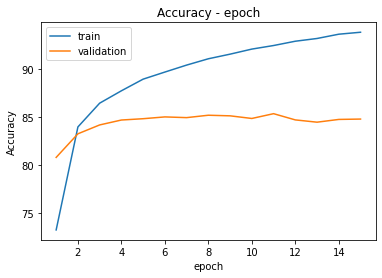

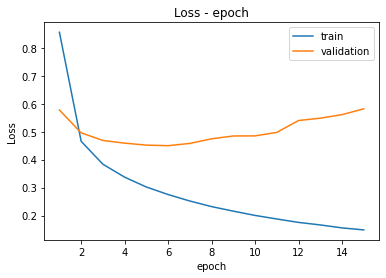

In [15]:
plotGraph(y1=trainAcc_curve, x1=epoch_cnt, y2=valAcc_curve, x2=epoch_cnt)
plotGraph(y1=trainLoss_curve, x1=epoch_cnt, y2=valLoss_curve, x2=epoch_cnt, y_axis='Loss')

# your test prediction on test data

#upload csv to kaggle and get your score

In [16]:
test_pred_list = []

for tit in range(test_image_num//Batch_size):
    pred, test_loss = net.forward(test_data[tit*Batch_size:(tit+1)*Batch_size], train_label_onehot[tit*Batch_size:(tit+1)*Batch_size])
    pred_index = np.argmax(pred, axis=1)
    test_pred_list += pred_index.tolist()
    

print('Dump file...')
df = pd.DataFrame(test_pred_list, columns=["Category"])
df.to_csv('test-predict.csv', index=True, index_label="Id")

Dump file...
